## MSDS 432 - Programming Assignment #7 Dan Avni

## Executive Summary

The purpose of this programming assignment is to provide a "real-world" demonstration of the runtime performance of the breadth-first-search (BFS) algorithm. BFS is a long-standing key algorithm in the study of graph and tree search and traversal, with applications ranging from network community detection to shortest distance search. 

BFS search strategy is to traverse the tree or graph level by level, by queuing nodes in a first-in-first-out data structure.  

BFS worst-case runtime performance in the $Big O$ notation is $O(|V| + |E|)$ with $|V|$ representing the number of vertices in the graph and $|E|$ representing the number of edges. 

We demonstrate that BFS runtime performance increases the deeper the searched item resides in the tree. Hence, for use cases where the deeper nested items are commonly searched, an alternative method such as depth-first-search (DFS) should be considered.


## Method and Conclusions

To demonstrate the BFS performance relative to the tree depth we constructed a five-level deep tree. The first level has five nodes, each connected to five child nodes. Each consecutive level continues this structure. The resulting tree spans 3905 nodes in total, with each level respectively including 5, 25, 125, 625, 3125 nodes.

We used the following naming convention when naming the nodes:

{Level N}{Parent N}{Leven N+1}{Child N}.

Thus, a sample node on the third level could be named: 122135, indicating the entire node's lineage: 12 -> 1221 -> 122135.

The below image depicts the first three levels of our graph with the BFS traversal order as overlay:

<img src="./tree.png" width="75%" height="75%">

We conduct a BFS search against each level, performing as many searches as the level depth.

The below chart shows the mean BFS results, clearly illustrating the performance degradation corresponding to a deeper level search.

<img src="./runtime5.png">

## Implementation

In [1]:
#import required packages
from collections import deque
import heapq
import pandas as pd
import time
import matplotlib.pyplot as plt
import pydotplus as pdp
from IPython.display import Image 

In [2]:
graph_data = \
[
    ('NYC', 'DC', 2),
    ('NYC', 'Pittsbug', 7),
    ('NYC', 'Indianapolis', 11),
    ('DC', 'Atlanta', 2,),
    ('Indianapolis', 'Kansas City', 8),
    ('Pittsbug', 'Cincinati', 6),
    ('Atlanta', 'New Orleans', 2),
    ('Kansas City', 'Denver', 7),
    ('Cincinati', 'St Louis', 8,),
    ('New Orleans', 'Dallas', 2),
    ('Denver', 'Salt Lake City', 6,),
    ('Dallas', 'Albuquerque', 2,),
    ('St Louis', 'Oklahoma City', 7,),
    ('Oklahoma City', 'Albuquerque', 9),
    ('Albuquerque', 'Phoenix', 2),
    ('Salt Lake City', 'Las Vegas', 9),
    ('Phoenix', 'San Diego', 5),
    ('Phoenix', 'Las Vegas', 2),
    ('San Diego', 'Los Angeles', 2),
    ('Las Vegas', 'San Diego', 2), 
    ('Las Vegas', 'Los Angeles', 5)
]

In [3]:
# the graph
graph = {}

for item in graph_data:
    source, destination, cost = item
    if source not in graph:
        graph[source] = []
    graph[source].append((destination, cost))
    
# prepare data frame to hold test results    
test_results_col_names = ['method', 'runtime_ms']
test_results           = pd.DataFrame(columns = test_results_col_names) 

In [4]:
#Dijkstra shortest-path implementation created from Pseudocode here:
#https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm

def create_node_set(graph):
    node_set = set()
    for key in graph.keys():
        node_set.add(key)
        for (child,cost) in graph[key]:
            node_set.add(child)
    return node_set
    
def find_closest(node_set, dist):
    closest_node = None
    closest_dist = float("inf")
   
    for node in node_set:
        if  dist[node] < closest_dist:
            closest_node = node
            closest_dist = dist[node]
            
    return closest_node

def create_path(start, finish, prev, dist):
    path = deque()
    node = finish
   
    if node in prev or node == start:
        while node != None:
            path.appendleft((node,dist[node]))
            node = prev[node]
    return path

In [5]:
def find_shortest_path(graph, start, finish):
    node_set = create_node_set(graph)
    Inf  = float("inf")
    dist = {}
    prev = {}
    
    for node in node_set:
        dist[node] = Inf
        prev[node] = None
        
    dist[start] = 0
    
    while len(node_set):
        closest = find_closest(node_set, dist)
        
        node_set.remove(closest)
        if closest == finish:
            break
        
        for target, distance in graph[closest]:
            alt = dist[closest] + distance
            if alt < dist[target]:
                dist[target] = alt
                prev[target] = closest
            
    return list(create_path(start, finish, prev, dist)), dist[finish]

In [6]:
for i in range(0,24):
    start   = time.time()
    dijkstra_path, dijkstra_cost = find_shortest_path(graph, 'NYC', 'Los Angeles')
    runtime_ms = ((time.time() - start) * 1000)
    test_results.loc[len(test_results)] = ['Dijkstra', runtime_ms]

In [7]:
dijkstra_path, dijkstra_cost

([('NYC', 0),
  ('DC', 2),
  ('Atlanta', 4),
  ('New Orleans', 6),
  ('Dallas', 8),
  ('Albuquerque', 10),
  ('Phoenix', 12),
  ('Las Vegas', 14),
  ('San Diego', 16),
  ('Los Angeles', 18)],
 18)

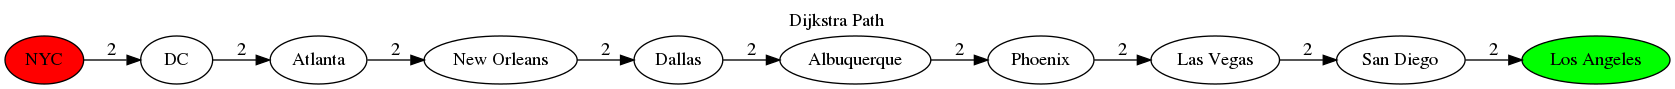

In [8]:
path_as_dot = '\"{}\" [fillcolor=red, style=filled] \"{}\" [fillcolor=green, style=filled]'.\
  format(dijkstra_path[0][0], dijkstra_path[len(dijkstra_path)-1][0])

for i in range(0, len(dijkstra_path)-1):
    path_as_dot += '\"{}\"->\"{}\"'.format(dijkstra_path[i][0], dijkstra_path[i+1][0]) 
    path_as_dot += '[label =\"{}\"];'.format(dijkstra_path[i+1][1] -dijkstra_path[i][1] ) 
  
path_graph = pdp.graph_from_dot_data('digraph { label="Dijkstra Path"; labelloc = "t"; rankdir="LR"; ' + path_as_dot + '}')
 
Image(path_graph.create_png())

In [9]:
def find_shortest_path_pq(graph, start, finish):
    node_set = create_node_set(graph)
    Inf    = float("inf")
    dist   = {}
    prev   = {}
    pq     = []
    finder = {}
    
    dist[start] = 0

    for node in node_set:
        if node != start:
            dist[node] = Inf
        prev[node] = None
        item = [dist[node], node]
        heapq.heappush(pq, item)
        finder[node] = item

    while len(pq):
        item = heapq.heappop(pq)
        distance, closest = item[0], item[1]
        if closest == finish:
            break
        
        for target, distance in graph[closest]:
            alt = dist[closest] + distance
            if alt < dist[target]:
                dist[target]   = alt
                prev[target]   = closest
                pq.remove(finder[target])
                item = [alt, target]
                finder[target] = item
                heapq.heappush(pq, item)

    return list(create_path(start, finish, prev, dist)), dist[finish]

In [10]:
for i in range(0,24):
    start   = time.time()
    dijkstra_pq_path, dijkstra_pq_cost = find_shortest_path_pq(graph, 'NYC', 'Los Angeles')
    runtime_ms = ((time.time() - start) * 1000)
    test_results.loc[len(test_results)] = ['Dijkstra PQ', runtime_ms]

In [11]:
dijkstra_pq_path, dijkstra_pq_cost

([('NYC', 0),
  ('DC', 2),
  ('Atlanta', 4),
  ('New Orleans', 6),
  ('Dallas', 8),
  ('Albuquerque', 10),
  ('Phoenix', 12),
  ('Las Vegas', 14),
  ('San Diego', 16),
  ('Los Angeles', 18)],
 18)

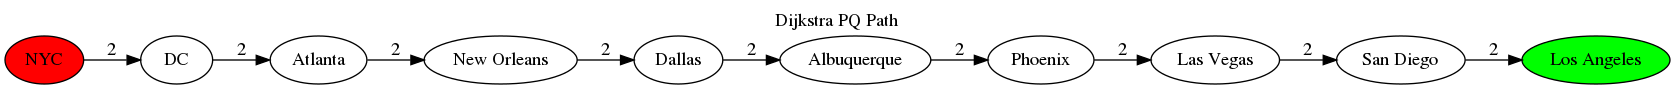

In [12]:
path_as_dot = '\"{}\" [fillcolor=red, style=filled] \"{}\" [fillcolor=green, style=filled]'.\
  format(dijkstra_pq_path[0][0], dijkstra_path[len(dijkstra_pq_path)-1][0])

for i in range(0, len(dijkstra_path)-1):
    path_as_dot += '\"{}\"->\"{}\"'.format(dijkstra_pq_path[i][0], dijkstra_pq_path[i+1][0]) 
    path_as_dot += '[label =\"{}\"];'.format(dijkstra_pq_path[i+1][1] -dijkstra_pq_path[i][1] ) 
  
path_graph = pdp.graph_from_dot_data('digraph { label="Dijkstra PQ Path"; labelloc = "t";rankdir="LR"; ' + path_as_dot + '}')
 
Image(path_graph.create_png())

In [13]:
#breadth-first-search (bfs) implementation adapted and heavily modified from: 
#https://github.com/egonSchiele/grokking_algorithms/

def breadth_first_shortest_path(graph, start, finish):
    search_queue = deque([(start, [(start,0)])])
    # This set is how you keep track of which items you've searched before.
    searched = set()
    while search_queue:
        cur_item, history = search_queue.popleft()
        if cur_item == finish:
            return history, sum(map(lambda d: d[1], history)) 
        # Only search this item if you haven't already searched them.
        if cur_item not in searched:
            for child, dist in graph[cur_item]:
                child_history = history.copy()
                child_history.append((child, dist))
                search_queue.append((child, child_history))
            # Marks this item as searched
            searched.add(cur_item)
    return None, None

In [14]:
for i in range(0,24):
    start   = time.time()
    bfs_path, bfs_cost = breadth_first_shortest_path(graph, 'NYC', 'Los Angeles')
    runtime_ms = ((time.time() - start) * 1000)
    test_results.loc[len(test_results)] = ['BFS', runtime_ms]

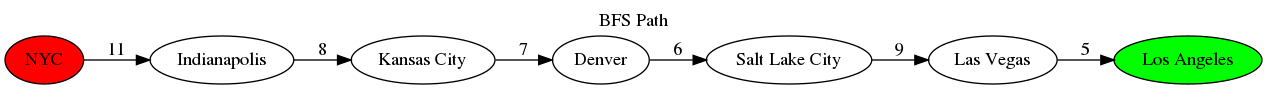

In [15]:
path_as_dot = '\"{}\" [fillcolor=red, style=filled] \"{}\" [fillcolor=green, style=filled]'.\
  format(bfs_path[0][0], bfs_path[len(bfs_path)-1][0])

for i in range(0, len(bfs_path)-1):
    path_as_dot += '\"{}\"->\"{}\"'.format(bfs_path[i][0], bfs_path[i+1][0]) 
    path_as_dot += '[label =\"{}\"];'.format(bfs_path[i+1][1] ) 
  
path_graph = pdp.graph_from_dot_data('digraph {label="BFS Path"; labelloc = "t"; rankdir="LR"; ' + \
                                     path_as_dot + '}')
 
Image(path_graph.create_png())

In [22]:
#prepare an empty data frame with the desired column names
test_results_mean_col_names = ['method', 'mean_runtime_ms', 'distance', 'hops']
test_results_mean           = pd.DataFrame(columns = test_results_mean_col_names) 

dijkstra_mean = test_results.loc[test_results['method']=='Dijkstra', 'runtime_ms'].mean()
test_results_mean.loc[len(test_results_mean)] = \
  ['Dijakstra', dijkstra_mean, dijkstra_cost, len(dijkstra_path)]

dijkstra_pq_mean = test_results.loc[test_results['method']=='Dijkstra PQ', 'runtime_ms'].mean()
test_results_mean.loc[len(test_results_mean)] = \
  ['Dijakstra Priority Queue', dijkstra_pq_mean, dijkstra_pq_cost, len(dijkstra_pq_path)]

bfs_mean = test_results.loc[test_results['method']=='BFS', 'runtime_ms'].mean()
test_results_mean.loc[len(test_results_mean)] = \
  ['BFS', bfs_mean, bfs_cost, len(bfs_path)]

test_results_mean

,method,mean_runtime_ms,distance,hops
0,Dijakstra,0.084857,18,10
1,Dijakstra Priority Queue,0.125776,18,10
2,BFS,0.047088,46,7


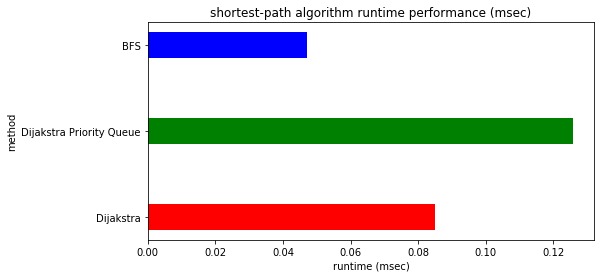

In [25]:
#prdoduce a bar plot of the mean search time by level
plt.figure(figsize=(8,4))
plt.barh(test_results_mean.method, test_results_mean.mean_runtime_ms, height=0.3, 
         color=['red', 'green',  'blue'])
plt.ylabel('method')
plt.xlabel('runtime (msec)')
plt.title('shortest-path algorithm runtime performance (msec)')
plt.show()

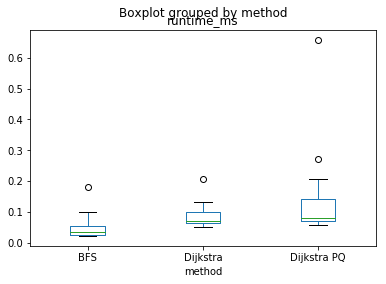

In [24]:
#pd.options.display.mpl_style = 'default'

test_results.boxplot(by='method', column='runtime_ms', grid=False)

## Extra work 

We traverse the tree to demonstrate the search order and visualize the results using the pydotplus package and GraphViz, a graph visualization package using the DOT langauge to construct graphs and tree.

We use a 3-level tree to produce a human-friendly plot.

In [329]:
def breadth_first_traverse(graph, start, finish):
    step = 0
    search_queue = deque([start])
    # This set is how you keep track of which items you've searched before.
    searched = set()
    output = '\"{}\" [fillcolor=red, style=filled] \"{}\" [fillcolor=green, style=filled]'.\
          format(start, finish)
    while search_queue:
        cur_item = search_queue.popleft()
        # Only search this item if you haven't already searched them.
        if cur_item not in searched:
            output += \
            "\"{}\" [label=\"{}\", xlabel=\"{}\"];".format(cur_item, cur_item, step)
            if cur_item == finish:
                break
            for child, distance in graph[cur_item]:
                output += "\"{}\"->\"{}\" [label={}];".format(cur_item, child, distance)
                search_queue.append(child)
            # Marks this item as searched
            step += 1
            searched.add(cur_item)
    return 'digraph {' + output + '}';

In [330]:
tree_as_dot = breadth_first_traverse(graph, 'NYC', 'Los Angeles')

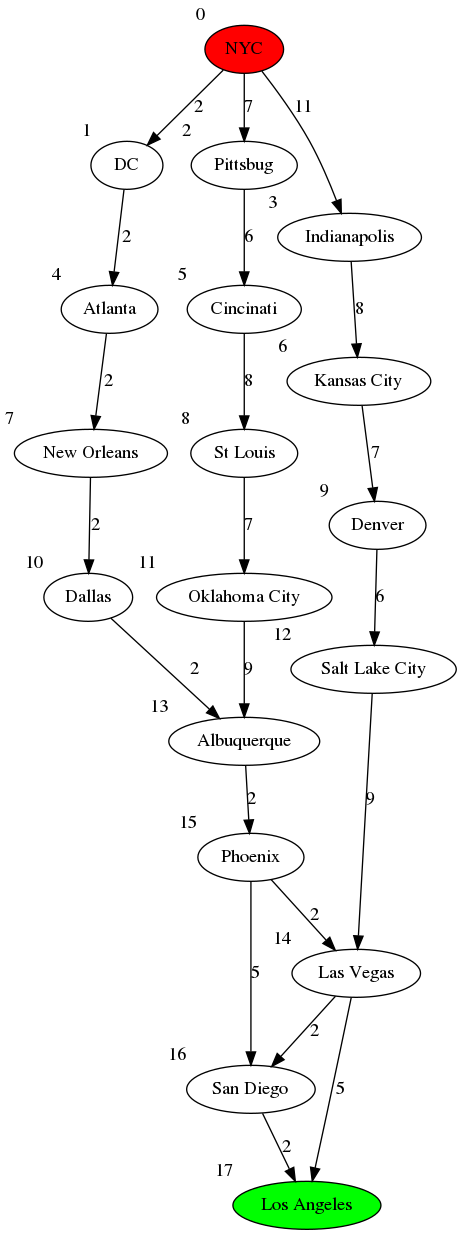

In [331]:
path_graph = pdp.graph_from_dot_data(tree_as_dot)
 
Image(path_graph.create_png())